In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [2]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
import matplotlib.pyplot as plt
import matplotlib.cm as mpl
import seaborn as sns
import statsmodels.api as sm
from multipy.fdr import qvalue
from multipy.fdr import lsu

import dill

import fit_sbm
import trim_networks
import export_blocks

In [3]:
with open ("../data/output/SBM/clustering/body_weights-spearman_fdr-1e-05_mcmc_mode_hierarchical-SBM.dill", "rb") as fh:
    bs_body = dill.load(fh)
bs_body = bs_body[0:5]

In [4]:
gf_body = load_graph("../data/output/SBM/graphs/body_fdrLevel-1e-05_genes-3253_density-0.052.xml.gz")
corr = gf_body.edge_properties["spearman"]

gf_body.ep.z_s = gf_body.new_edge_property("double", (2*np.arctanh(corr.a)))

block_df_body = pd.read_csv("../data/output/SBM/clustering/body_weights-spearman_fdr-1e-05_mcmc_mode_hierarchical-SBM.csv")

state_body = minimize_nested_blockmodel_dl(gf_body, init_bs=bs_body, 
                                      state_args=dict(recs=[gf_body.ep.z_s],
                                                      rec_types=["real-normal"]))

In [5]:
with open ("../data/output/SBM/clustering/head_weights-spearman_fdr-1e-04_mcmc_mode_hierarchical-SBM.dill", "rb") as fh:
    bs_head = dill.load(fh)
bs_head = bs_head[0:5]

In [6]:
gf_head = load_graph("../data/output/SBM/graphs/head_fdrLevel-0.0001_genes-3589_density-0.021.xml.gz")
corr = gf_head.edge_properties["spearman"]

gf_head.ep.z_s = gf_head.new_edge_property("double", (2*np.arctanh(corr.a)))

block_df_head = pd.read_csv("../data/output/SBM/clustering/head_weights-spearman_fdr-1e-04_mcmc_mode_hierarchical-SBM.csv")

state_head = minimize_nested_blockmodel_dl(gf_head, init_bs=bs_head, 
                                      state_args=dict(recs=[gf_head.ep.z_s],
                                                      rec_types=["real-normal"]))

In [ ]:
state_body.draw(edge_color=prop_to_size(gf_body.ep.z_s, mi=-4, ma=4, power=1, log=False),
                ecmap=(mpl.inferno, .6), edge_gradient=[], vertex_text = state_body.get_bs()[0],
                eorder=gf_body.ep.z_s, subsample_edges = 1000, hsize_scale = 6.) 
                #output = "../data/output/SBM/plots/body_heatplot.png")

In [22]:
state_head.get_bs()[0]

PropertyArray([ 0,  1,  2, ..., 34, 41,  6], dtype=int32)

In [ ]:
state_head.draw(edge_color=prop_to_size(gf_head.ep.z_s, mi=-4, ma=4, power=1, log=False),
                ecmap=(mpl.inferno, .6), edge_gradient=[], 
                eorder=gf_head.ep.z_s,subsample_edges = 10000)
                #output = "../data/output/SBM/plots/head_heatplot.png")

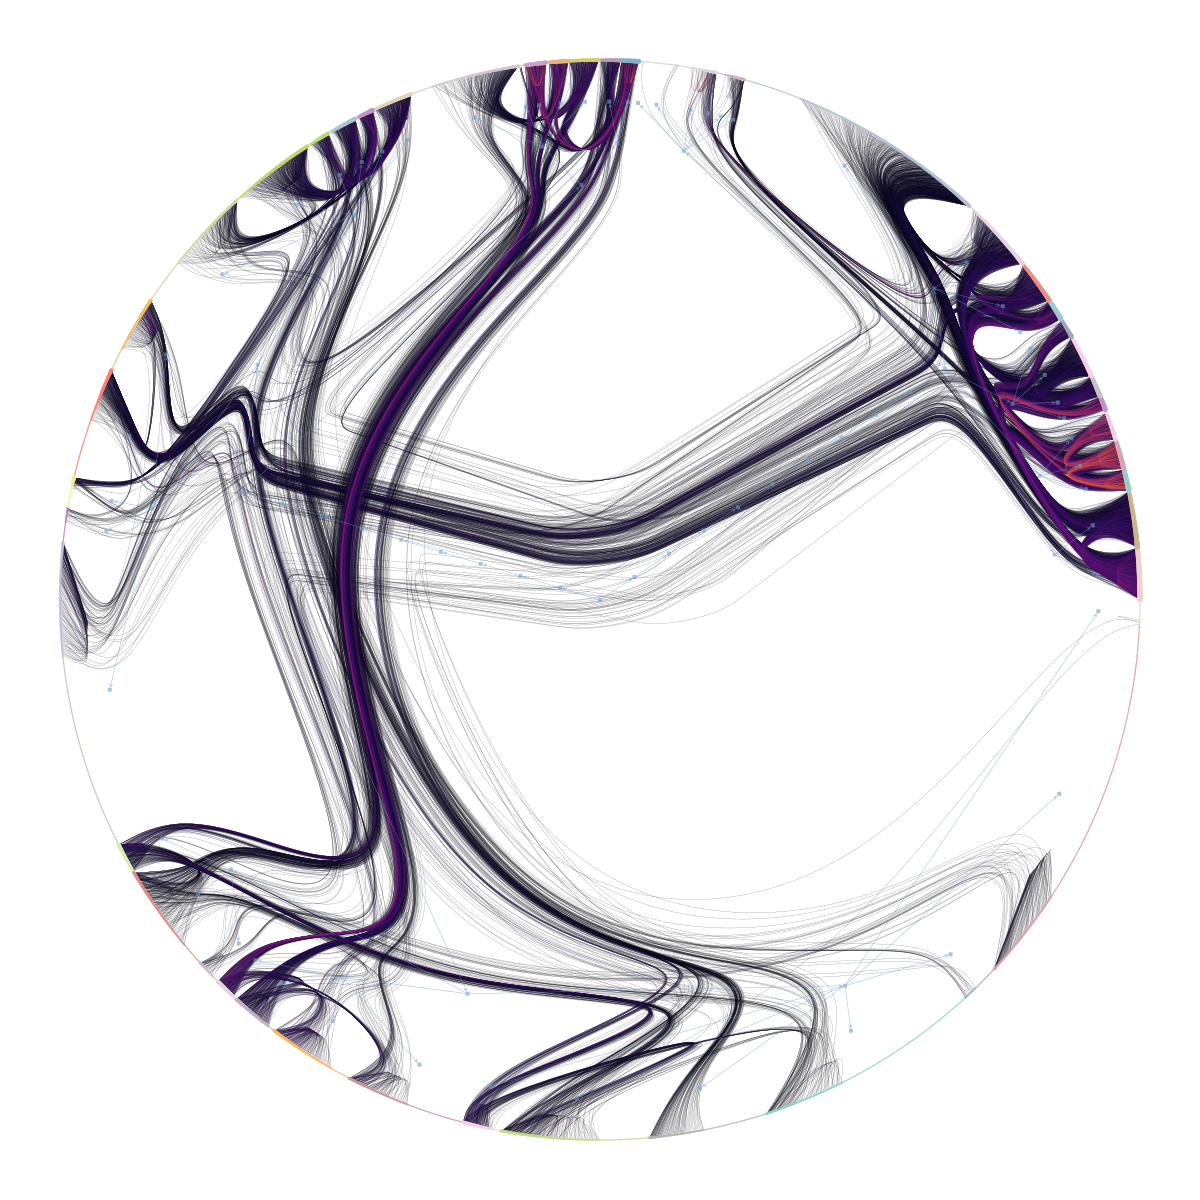

In [82]:
state_head.g = gf_head
layer_1 = state_head.g.new_ep("bool", True)
layer_1.a = state_head.g.ep.z_s.a > 0
state_head.g = GraphView(state_head.g, efilt=layer_1)
state_head.draw(edge_color=prop_to_size(state_head.g.ep.z_s, mi=-2, ma=4, power=1, log=False),
               ecmap=(mpl.inferno, .6), edge_gradient=[], 
               eorder=state_head.g.ep.z_s, subsample_edges = 10000)
state_head.g = gf_head

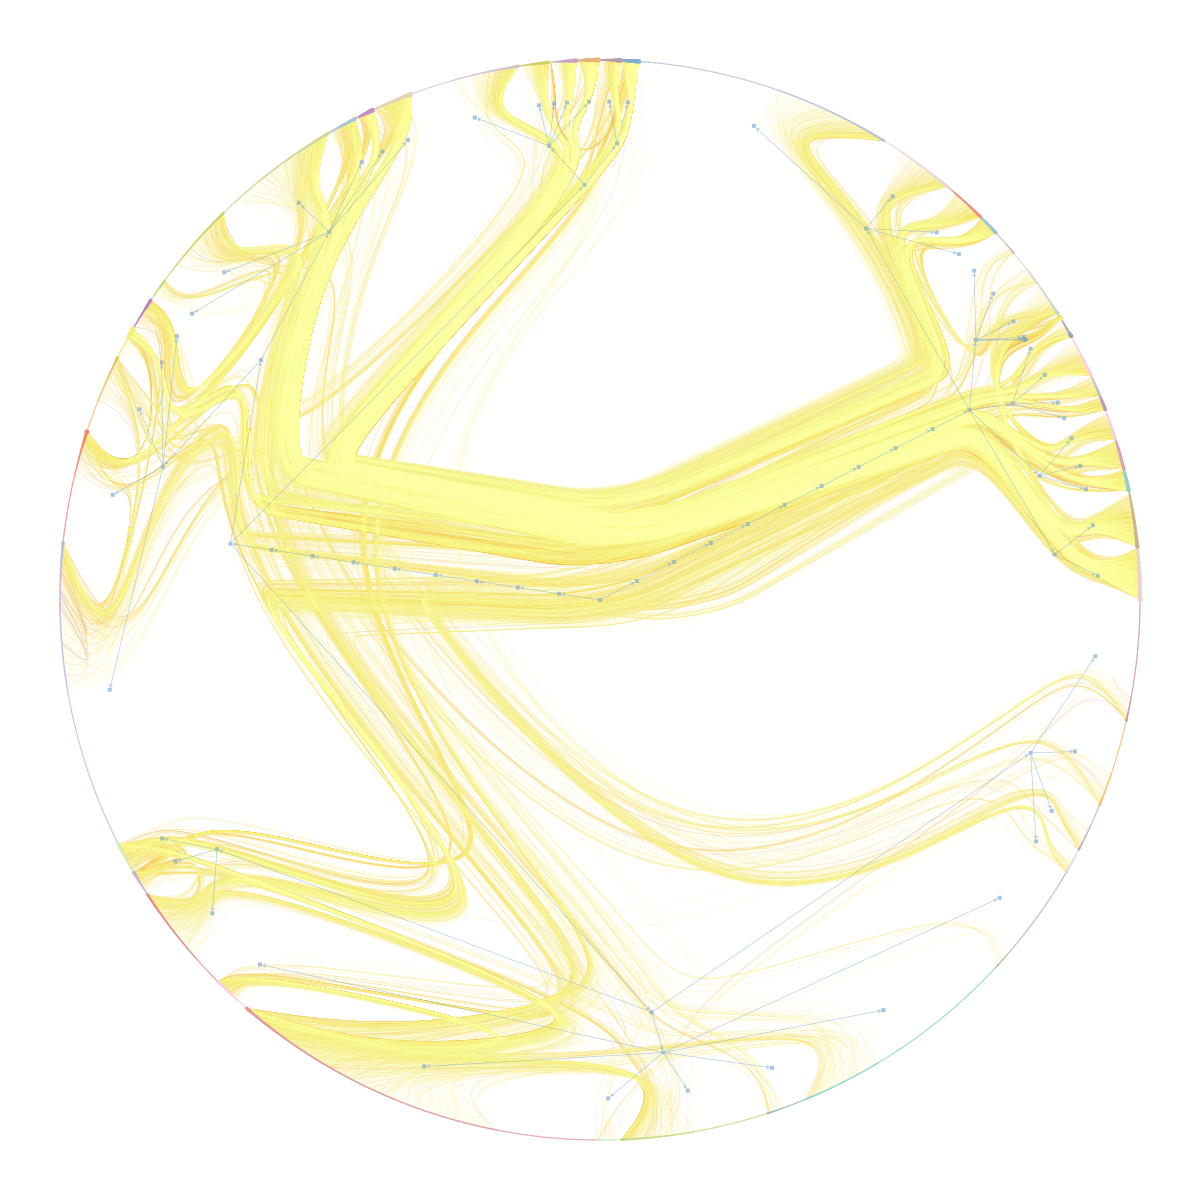

In [79]:
state_head.g = gf_head
layer_1 = state_head.g.new_ep("bool", True)
layer_1.a = state_head.g.ep.z_s.a < 0
state_head.g = GraphView(state_head.g, efilt=layer_1)
#state_head.draw()
state_head.draw(edge_color=prop_to_size(state_head.g.ep.z_s, mi=-2, ma=4, power=1, log=False),
               ecmap=(mpl.inferno, .6), edge_gradient=[], 
               eorder=state_head.g.ep.z_s)
state_head.g = gf_head

In [87]:
min(gf_body.ep.spearman.a)

-0.781993325266588

In [86]:
gf_body = load_graph("../data/output/SBM/graphs/body_fdrLevel-1e-05_genes-3253_density-0.052.xml.gz")


In [200]:
bs = []
h = [np.zeros(gf.num_vertices() + 1) for s in state_min.get_levels()]

def collect_partitions(s):
    global bs
    bs.append(s.get_bs())
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
   

# Now we collect the marginals for exactly 100,000 sweeps
mcmc_equilibrate(state_min, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

(313418.28701300896, 358726951, 20337151)

In [35]:
# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, nested=True, converge=True)

pv = pmode.get_marginal(gf)

# Get consensus estimate
bs_max = pmode.get_max_nested()

state = state_min.copy(bs=bs_max)

(313358.0505201311, 359634575, 21662086)

In [199]:
# Infer partition modes
pmode = ModeClusterState(bs, nested=True)

# Minimize the mode state itself
mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))

# Get inferred modes
modes = pmode.get_modes()

for i, mode in enumerate(modes):
    b = mode.get_max_nested()    # mode's maximum
    pv = mode.get_marginal(g)    # mode's marginal distribution

    print(f"Mode {i} with size {mode.get_M()/len(bs)}")
    state_mode = state.copy(bs=b)
    state_mode.draw()

TypeError: object of type 'numpy.int32' has no len()

In [194]:
pd.DataFrame(h).to_csv("../data/output/SBM/clustering/head_cutoff-spearman_val-0.4_hierarchical-SBM_levels_histogram.csv")


In [385]:
state_min_pp = minimize_blockmodel_dl(gf, state=PPBlockState)
mcmc_equilibrate(state_min_pp, wait = 100, mcmc_args=dict(niter=10))

(418119.08240070264, 68077196, 10316674)